<a href="https://colab.research.google.com/github/mickeykubo/fastai-v1/blob/master/lesson2_sgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl https://course-v3.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   665  100   665    0     0   1162      0 --:--:-- --:--:-- --:--:--  1164
Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (1.0.39)
Already up to date.


In [0]:
%matplotlib inline
from fastai.basics import *

In this part of the lecture we explain Stochastic Gradient Descent (SGD) which is an **optimization** method commonly used in neural networks. We will illustrate the concepts with concrete examples.

ここでは，確率的勾配降下法とよばれるニューラルネット用の最適化手法について述べる．
最初に概念を，次いで具体的な例を示す．

#  Linear Regression problem　（線形回帰）

The goal of linear regression is to fit a line to a set of points.

In [0]:
n=100

In [5]:
x = torch.ones(n,2) 
x[:,0].uniform_(-1.,1)
x[:5]

tensor([[-0.0588,  1.0000],
        [ 0.0730,  1.0000],
        [-0.6629,  1.0000],
        [ 0.4073,  1.0000],
        [-0.3247,  1.0000]])

In [6]:
a = tensor(3.,2); a

tensor([3., 2.])

In [0]:
y = x@a + torch.rand(n)

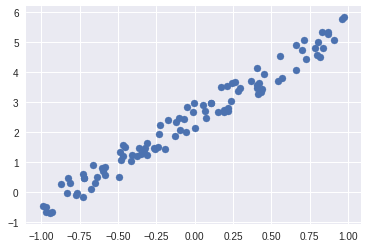

In [8]:
plt.scatter(x[:,0], y);

You want to find **parameters** (weights) `a` such that you minimize the *error* between the points and the line `x@a`. Note that here `a` is unknown. For a regression problem the most common *error function* or *loss function* is the **mean squared error**. 

誤差を最小化する重み（パラメータ）`a`を求める．損出関数は**平均2乗誤差**とする．


In [0]:
def mse(y_hat, y): return ((y_hat-y)**2).mean()

Suppose we believe `a = (-1.0,1.0)` then we can compute `y_hat` which is our *prediction* and then compute our error.

In [0]:
a = tensor(-1.,1)

In [11]:
y_hat = x@a
mse(y_hat, y)

tensor(6.6869)

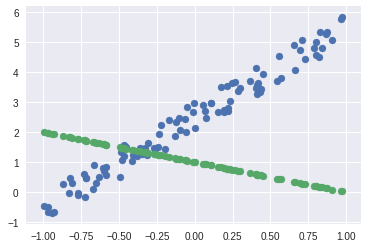

In [12]:
plt.scatter(x[:,0],y)
plt.scatter(x[:,0],y_hat);

So far we have specified the *model* (linear regression) and the *evaluation criteria* (or *loss function*). Now we need to handle *optimization*; that is, how do we find the best values for `a`? How do we find the best *fitting* linear regression.

# Gradient Descent（勾配降下法）

We would like to find the values of `a` that minimize `mse_loss`.

**Gradient descent** is an algorithm that minimizes functions. Given a function defined by a set of parameters, gradient descent starts with an initial set of parameter values and iteratively moves toward a set of parameter values that minimize the function. This iterative minimization is achieved by taking steps in the negative direction of the function gradient.

Here is gradient descent implemented in [PyTorch](http://pytorch.org/).

In [13]:
a = nn.Parameter(a); a

Parameter containing:
tensor([-1.,  1.], requires_grad=True)

In [0]:
def update():
    y_hat = x@a
    loss = mse(y, y_hat)
    if t % 10 == 0: print(loss)
    loss.backward()
    with torch.no_grad():
        a.sub_(lr * a.grad)
        a.grad.zero_()

In [15]:
lr = 1e-1
for t in range(100): update()

tensor(6.6869, grad_fn=<MeanBackward1>)
tensor(1.5659, grad_fn=<MeanBackward1>)
tensor(0.5083, grad_fn=<MeanBackward1>)
tensor(0.2089, grad_fn=<MeanBackward1>)
tensor(0.1229, grad_fn=<MeanBackward1>)
tensor(0.0982, grad_fn=<MeanBackward1>)
tensor(0.0911, grad_fn=<MeanBackward1>)
tensor(0.0890, grad_fn=<MeanBackward1>)
tensor(0.0884, grad_fn=<MeanBackward1>)
tensor(0.0883, grad_fn=<MeanBackward1>)


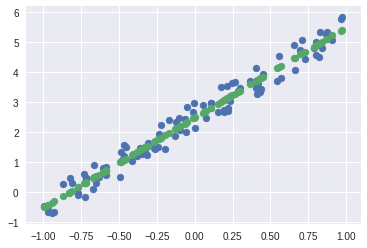

In [16]:
plt.scatter(x[:,0],y)
plt.scatter(x[:,0],x@a);

## Animate it!

In [0]:
from matplotlib import animation, rc
rc('animation', html='jshtml')

In [18]:
a = nn.Parameter(tensor(-1.,1))

fig = plt.figure()
plt.scatter(x[:,0], y, c='orange')
line, = plt.plot(x[:,0], x@a)
plt.close()

def animate(i):
    update()
    line.set_ydata(x@a)
    return line,

animation.FuncAnimation(fig, animate, np.arange(0, 100), interval=20)

In practice, we don't calculate on the whole file at once, but we use *mini-batches*.

## Vocab（用語）

- 学習率 Learning rate
- エポック Epoch
- ミニバッチMinibatch
- 確率的勾配降下法 SGD
- モデル・アーキテキクチャ Model / Architecture
- パラメータ Parameters
- 損出関数 Loss function

分類問題においては，交差エントロピー損出関数（負対数尤度関数）を用いる．

For classification problems, we use *cross entropy loss*, also known as *negative log likelihood loss*. This penalizes incorrect confident predictions, and correct unconfident predictions.